In [1]:
import os
try:
    %run setup_paths
except:
    %run notebooks/setup_paths
    
print("current dir: ", os.getcwd())

current dir:  c:\Projects\scmsim


In [2]:
import pandas as pd

# Load u.data
ratings = pd.read_csv(
    "ml-100k/u.data",
    sep="\t",
    names=["user_id", "movie_id", "rating", "timestamp"]
)

print(ratings.head())



   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596


In [5]:
movie_info = pd.read_csv(
    "ml-100k/u.item",
    sep="|",
    header=None,
    encoding="ISO-8859-1",  # prevents UnicodeDecodeError
    names=[
        "movie_id", "title", "release_date", "video_release_date", "IMDb_URL"
    ] + [f"genre_{i}" for i in range(19)]  # ignore genre columns for now
)

# Keep only the movie ID and title
movie_titles = movie_info[["movie_id", "title"]]

# Create a mapping from movie_id to title
movie_id_to_title = dict(zip(movie_titles.movie_id, movie_titles.title))


In [84]:
def verify_ids(ids):
    diff = set(ids)-set(range(1,len(ids)+1))
    assert len(diff)==0
verify_ids(ratings["user_id"])
verify_ids(ratings["movie_id"])

In [86]:
def get_watch_matrix(ratings):
    # Get the number of users and movies
    n_users = ratings['user_id'].max()
    n_movies = ratings['movie_id'].max()

    # Create a binary watch matrix: [n_users x n_movies]
    watch_matrix = torch.zeros((n_users, n_movies), dtype=torch.float32)

    # Fill in 1.0 for watched movies
    for row in ratings.itertuples(index=False):
        user_idx = row.user_id - 1  # user IDs start from 1
        movie_idx = row.movie_id - 1
        watch_matrix[user_idx, movie_idx] = 1.0
    return watch_matrix

In [116]:
def get_sate_matrix(mat):
    ## mat is movie x user matrix - will return AxB ate(A|B) matrix
    nmovies, nusers = mat.shape
    pAB = mat @ mat.transpose(0,1) / nusers
    pB = mat.sum(dim=1)/nusers
    pAgB = pAB/pB
    pAnB = pAB = mat @ (1-mat).transpose(0,1) / nusers
    pAgnB = pAnB / (1-pB)
    return pAgB-pAgnB

def get_sate_table(ate):
    df = pd.DataFrame(dict(
        sate=ate.flatten().numpy(), 
        resp_idx=1+torch.arange(ate.shape[0]).unsqueeze(1).expand(ate.shape).flatten().numpy(), 
        treatment_idx=1+torch.arange(ate.shape[0]).unsqueeze(0).expand(ate.shape).flatten().numpy() ) )
    df = df[df["resp_idx"] != df["treatment_idx"]]
    return df

def add_movie_titles(df, movie_titles, resp_col="resp_idx", treat_col="treatment_idx"):
    df = df.copy()
    df["resp_title"] = df[resp_col].map(movie_titles)
    df["treatment_title"] = df[treat_col].map(movie_titles)
    return df

In [96]:
watch_matrix = get_watch_matrix(ratings)

In [117]:
sate = get_sate_matrix(watch_matrix)

In [118]:
sdf = get_sate_table(sate)

In [119]:
sdf.sort_values(by=["sate"], ascending=False)

,sate,resp_idx,treatment_idx
424522,0.966443,451,173
682069,0.964372,724,281
846278,0.960546,898,408
553453,0.956522,587,856
553407,0.956522,587,810
...,...,...,...
381877,-0.449116,405,906
381693,-0.449390,405,722
381763,-0.450765,405,792
381328,-0.458904,405,357


In [120]:
#movie_titles
esdf = add_movie_titles(sdf, movie_id_to_title)

In [121]:
esdf

,sate,resp_idx,treatment_idx,resp_title,treatment_title
1,0.133532,1,2,Toy Story (1995),GoldenEye (1995)
2,-0.014014,1,3,Toy Story (1995),Four Rooms (1995)
3,0.131836,1,4,Toy Story (1995),Get Shorty (1995)
4,0.329737,1,5,Toy Story (1995),Copycat (1995)
5,0.335330,1,6,Toy Story (1995),Shanghai Triad (Yao a yao yao dao waipo qiao) ...
...,...,...,...,...,...
889243,0.160419,943,938,Killing Zoe (1994),"Smile Like Yours, A (1997)"
889244,0.149368,943,939,Killing Zoe (1994),Murder in the First (1995)
889245,0.172793,943,940,Killing Zoe (1994),Airheads (1994)
889246,0.129080,943,941,Killing Zoe (1994),With Honors (1994)


In [123]:
esdf.to_csv("products/MovieLensPairsSate.csv")

In [142]:
esdfr = esdf.copy()
esdfr = esdfr.sort_values(by="sate", ascending=True)
scores = np.arange(len(esdfr)) 
esdfr["scoreA"] = scores
esdfr = esdfr.sort_values(by="sate", ascending=False)
esdfr["scoreB"] = scores
esdfr["rnd"] = np.random.rand(len(esdfr))
esdfr = esdfr.sort_values(by="rnd", ascending=False)
esdfr["scoreC"] = scores
esdfr["score"] = np.minimum(esdfr["scoreA"],esdfr["scoreB"])
esdfr["score"] = np.minimum(esdfr["score"],esdfr["scoreC"])
esdfr = esdfr.sort_values(by="score", ascending=True)
esdfr = esdfr.reset_index().copy()[["treatment_idx", "resp_idx", "treatment_title","resp_title","sate"]]

esdfr

,treatment_idx,resp_idx,treatment_title,resp_title,sate
0,519,678,"Treasure of the Sierra Madre, The (1948)",Volcano (1997),0.003874
1,181,405,Return of the Jedi (1983),Mission: Impossible (1996),-0.525902
2,173,451,"Princess Bride, The (1987)",Grease (1978),0.966443
3,821,228,Mrs. Winterbourne (1996),Star Trek: The Wrath of Khan (1982),0.054022
4,357,405,One Flew Over the Cuckoo's Nest (1975),Mission: Impossible (1996),-0.458904
...,...,...,...,...,...
888301,332,45,Kiss the Girls (1997),Eat Drink Man Woman (1994),0.109005
888302,775,480,Something to Talk About (1995),North by Northwest (1959),0.109000
888303,609,745,Father of the Bride (1950),"Ruling Class, The (1972)",0.109000
888304,838,534,In the Line of Duty 2 (1987),Traveller (1997),0.109002


In [143]:
esdfr.to_csv("products/MovieLensPairsSateShuf.csv")

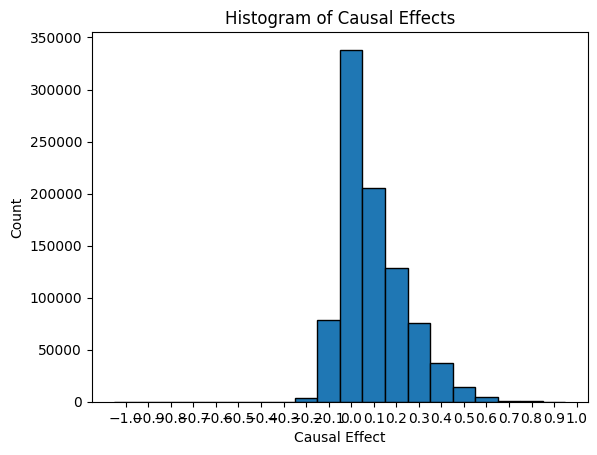

In [130]:
import numpy as np
import matplotlib.pyplot as plt

# Example NumPy array of causal effect values
values = esdf["sate"]

# Simple histogram
bins = [x/10.0 for x in range(-10, 11)]
plt.hist(values, bins=bins, edgecolor='black', align='left')
plt.xlabel("Causal Effect")
plt.ylabel("Count")
plt.title("Histogram of Causal Effects")
plt.xticks(bins)
plt.show()

In [146]:
list(zip([1,2,3],[1,2]))

[(1, 1), (2, 2)]